<table border="" width=100% cellpadding=0><tr>
<td bgcolor="#232323" border="">
<img src="https://raw.github.com/profLewis/geogg122/master/images/logo.png"></td>
</tr>
<td bgcolor="#9ABAE2" border="">
</td>
</table>

# Read and use some different file formats

In this session, we will learn to use some geospatial tools using GDAL in Python. A good set of working notes on how to use GDAL has been developed that you will find useful for background reading.

[HDF](http://www.hdfgroup.org/HDF-FAQ.html)(Hierarchical Data Format) and [HDF-EOS](http://hdfeos.org/) are common formats for EO data so you need to have some idea how to use and manipulate them.

A hierarchical data format is essentially a format that ‘packs’ together various aspects of a dataset (metadata, raster data etc.) into a binary file. There are many tools for manipulating and reading HDF in python, but we will use one of the more generic tools, [gdal](http://gdal.org) here.

When using HDF files, we need to have some idea of the stucture of the contents, although you can clearly explore that yourself in an interactive session. MODIS products have extensive information available to help you interpret the datasets, for example the MODIS LAI/fAPAR product [MOD15A2](https://lpdaac.usgs.gov/products/modis_products_table/leaf_area_index_fraction_of_photosynthetically_active_radiation/8_day_l4_global_1km/mod15a2). We will use this as an example to explore a dataset.

You will need access to the file [`MCD15A2.A2011185.h09v05.005.2011213154534.hdf`](http://www2.geog.ucl.ac.uk/~plewis/geogg122/_images/MCD15A2.A2011185.h09v05.005.2011213154534.hdf), which you might access from the [MODIS Land Products site](https://lpdaac.usgs.gov/)

Before going into the Python coding for GDAL, it is worthwhile looking over some of the tools that are provided with GDAL and that can be run from the shell. In particular, we can use the `gdalinfo` program, that takes a filename and will output a copious description of the data, including metadata, but also geogrpahic projection, size, number of bands, etc.

In [3]:
!gdalinfo MCD15A2.A2011185.h09v05.005.2011213154534.hdf 

Driver: HDF4/Hierarchical Data Format Release 4
Files: MCD15A2.A2011185.h09v05.005.2011213154534.hdf
Size is 512, 512
Coordinate System is `'
Metadata:
  HDFEOSVersion=HDFEOS_V2.9
  LOCALGRANULEID=MCD15A2.A2011185.h09v05.005.2011213154534.hdf
  PRODUCTIONDATETIME=2011-08-01T15:45:34.000Z
  DAYNIGHTFLAG=Day
  REPROCESSINGACTUAL=reprocessed
  LOCALVERSIONID=5.0.4
  REPROCESSINGPLANNED=further update is anticipated
  SCIENCEQUALITYFLAG=Not Investigated
  AUTOMATICQUALITYFLAGEXPLANATION=No automatic quality assessment is performed in the PGE
  AUTOMATICQUALITYFLAG=Passed
  SCIENCEQUALITYFLAGEXPLANATION=See http://landweb.nascom/nasa.gov/cgi-bin/QA_WWW/qaFlagPage.cgi?sat=aqua the product Science Quality status.
  QAPERCENTMISSINGDATA=3
  QAPERCENTOUTOFBOUNDSDATA=3
  QAPERCENTCLOUDCOVER=23
  QAPERCENTINTERPOLATEDDATA=0
  PARAMETERNAME=MCD15A2
  VERSIONID=5
  SHORTNAME=MCD15A2
  INPUTPOINTER=MYD15A1.A2011192.h09v05.005.2011194222549.hdf, MYD15A1.A2011191.h09v05.005.2011194224921.hdf, MYD15A1.

In [4]:
# Filter lines that do not have BOUNDINGCOORDINATE in them
!gdalinfo MCD15A2.A2011185.h09v05.005.2011213154534.hdf | grep BOUNDINGCOORDINATE

  NORTHBOUNDINGCOORDINATE=39.9999999964079
  SOUTHBOUNDINGCOORDINATE=29.9999999973059
  EASTBOUNDINGCOORDINATE=-92.3664205550513
  WESTBOUNDINGCOORDINATE=-117.486656023174


We can check this against e.g. the [UNH MODIS tile calculator](http://remotesensing.unh.edu/modis/modis.shtml), just to confirm that we have interpreted the coordinates correctly.

We can apply other shell GDAL tools, e.g. to perform a reprojection from the native [MODIS sinusoidal](http://modis-land.gsfc.nasa.gov/MODLAND_grid.html) projection, to the [Contiguous United States NAD27 Albers Equal Area](http://spatialreference.org/ref/sr-org/7271/):

In [7]:
!gdalwarp -of GTiff \
    -t_srs '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=clrk66 +units=m +no_defs'  \
    -tr 1000 1000 \
    'HDF4_EOS:EOS_GRID:MCD15A2.A2011185.h09v05.005.2011213154534.hdf:MOD_Grid_MOD15A2:Lai_1km' output_file.tif

Creating output file that is 2152P x 1323L.
Processing input file HDF4_EOS:EOS_GRID:MCD15A2.A2011185.h09v05.005.2011213154534.hdf:MOD_Grid_MOD15A2:Lai_1km.
Using internal nodata values (eg. 255) for image HDF4_EOS:EOS_GRID:MCD15A2.A2011185.h09v05.005.2011213154534.hdf:MOD_Grid_MOD15A2:Lai_1km.
0...10...20...30...40...50...60...70...80...90...100 - done.


where `MCD15A2.A2011185.h09v05.005.2011213154534.hdf` is the name of the input HDF file, `MOD_Grid_MOD15A2:Lai_1km` is the data product we want, and the rather menacing string `+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=clrk66 +units=m +no_defs` specifies the projection in Proj4 format. You can typically find the projection you want on [spatialreference.org](http://spatialreference.org), and just copy and paste the contents of [Proj4 definition](http://spatialreference.org/ref/sr-org/7271/proj4/) (remember to surround it by quotes). The option `-tr xres yres` specifies the desired resolution of the output dataset (1000 by 1000 m in the case above). `-of GTiff` specifies the GeoTiff format to be used as as output.

Having some idea what information is in the hdf file then, we can proceed to read the data in inside Python using the GDAL library:

In [18]:
import gdal # Import GDAL library bindings

# The file that we shall be using
# Needs to be on current directory
filename = 'MCD15A2.A2011185.h09v05.005.2011213154534.hdf'

g = gdal.Open(filename)
# g should now be a GDAL dataset, but if the file isn't found
# g will be none. Let's test this:
if g is None:
    print "Problem opening file %s!" % filename
else:
    print "File %s opened fine" % filename
    
    
subdatasets = g.GetSubDatasets()
for fname, name in subdatasets:
    print name
    print "\t", fname



File MCD15A2.A2011185.h09v05.005.2011213154534.hdf opened fine
[1200x1200] Fpar_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Fpar_1km
[1200x1200] Lai_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Lai_1km
[1200x1200] FparLai_QC MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparLai_QC
[1200x1200] FparExtra_QC MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparExtra_QC
[1200x1200] FparStdDev_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparStdDev_1km
[1200x1200] LaiStdDev_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":

In the previous code snippet we have done a number of different things:

1. Import the GDAL library
2. Open a file with GDAL, storing a handler to the file in `g`
3. Test that `g` is not `None` (as this indicates failure opening the file. Try changing `filename` above to something else)
4. We then use the `GetSubDatasets()` method to read out information on the different subdatasets available from this file (compare to the output of `gdalinfo` on the shelf earlier)
5. Loop over the retrieved subdatasets to print the name (human-readable information) and the GDAL filename. This last item is the filename that you need to use to tell GDAL to open a particular data layer of the 6 layers present in this example

Let's say that we want to access the LAI information. By contrasting the output of the above code (or `gdalinfo`) to the contents of the [LAI/fAPAR product information page](https://lpdaac.usgs.gov/products/modis_products_table/leaf_area_index_fraction_of_photosynthetically_active_radiation/8_day_l4_global_1km/mod15a2), we find out that we want the layers for `Lai_1km`, `FparLai_Qc`, `FparExtra_QC` and `LaiStdDev_1km`. 

To read these individual datasets, we need to open each of them individually using GDAL, and the GDAL filenames used above:

In [24]:
# Let's create a list with the selected layer names
selected_layers = [  "Lai_1km", "FparLai_QC", "FparExtra_QC",  "LaiStdDev_1km" ]
# We will store the data in a dictionary
# Initialise an empty dictionary
data = {}
# for convenience, we will use string substitution to create a 
# template for GDAL filenames, which we'll substitute on the fly:
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
for i, layer in enumerate ( selected_layers ):
    this_file = file_template % ( filename, layer )
    print "Opening Layer %d: %s" % (i+1, this_file )
    g = gdal.Open ( this_file )
    
    if g is None:
        raise IOError
    data[layer] = g.ReadAsArray() 
    print "\t>>> Read %s!" % layer
    

Opening Layer 1: HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Lai_1km
	>>> Read Lai_1km!
Opening Layer 2: HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparLai_QC
	>>> Read FparLai_QC!
Opening Layer 3: HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparExtra_QC
	>>> Read FparExtra_QC!
Opening Layer 4: HDF4_EOS:EOS_GRID:"MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:LaiStdDev_1km
	>>> Read LaiStdDev_1km!


In the previous code, we have seen a way of neatly creating the filenames required by GDAL to access the independent datasets: a template string that gets substituted with the `filename` and the `layer` name. Note that the presence of double quotes in the template requires us to use single quotes around it. The data is now stored in a dictionary, and can be accessed as e.g. `data['Lai_1km']`:

In [25]:
print read_data['Lai_1km']

[[ 3  3  2 ...,  6  8 21]
 [ 4  3  6 ...,  8 18 14]
 [ 3 12 11 ..., 12  8  8]
 ..., 
 [ 2  3  2 ..., 18 11 17]
 [ 2  3  3 ..., 16 19 15]
 [ 3  2  2 ..., 15 16 15]]


Now we have to translate the LAI values into meaningful quantities. According to the [LAI](https://lpdaac.usgs.gov/products/modis_products_table/leaf_area_index_fraction_of_photosynthetically_active_radiation/8_day_l4_global_1km/mod15a2) webpage, there is a scale factor of 0.1 involved for LAI and SD LAI:

In [26]:
lai = data['Lai_1km'] * 0.1
lai_sd = data['LaiStdDev_1km'] * 0.1

In [28]:
print "LAI"
print lai
print "SD"
print lai_sd

LAI
[[ 0.3  0.3  0.2 ...,  0.6  0.8  2.1]
 [ 0.4  0.3  0.6 ...,  0.8  1.8  1.4]
 [ 0.3  1.2  1.1 ...,  1.2  0.8  0.8]
 ..., 
 [ 0.2  0.3  0.2 ...,  1.8  1.1  1.7]
 [ 0.2  0.3  0.3 ...,  1.6  1.9  1.5]
 [ 0.3  0.2  0.2 ...,  1.5  1.6  1.5]]
SD
[[ 0.2  0.2  0.1 ...,  0.2  0.1  0.3]
 [ 0.2  0.2  0.2 ...,  0.2  0.3  0.2]
 [ 0.   0.1  0.2 ...,  0.1  0.2  0.2]
 ..., 
 [ 0.1  0.1  0.1 ...,  0.3  0.   0.1]
 [ 0.1  0.1  0.1 ...,  0.2  0.2  0.1]
 [ 0.1  0.1  0.1 ...,  0.1  0.2  0.1]]


Some SD values are clearly given as 0.0, which is unlikely to be true. We should then examine the QC (Quality Control) information. The codes for this are also given on the LAI product page. They are described as bit combinations:

<table>
<tr>
<th>Bit No.</th>	<th>Parameter Name</th><th>	Bit Combination</th><th>Explanation</th>
<tr>
<td>0	</td><td>MODLAND_QC bits</td><td>	0</td><td>	Good quality (main algorithm with or without saturation)	 	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Other Quality (back-up algorithm or fill values)	 	 </td>
</tr>

<tr>
<td>1	</td><td>Sensor</td><td>	0</td><td>	TERRA</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>AQUA</td>
</tr>

<tr>
<td>2	</td><td>DeadDetector</td><td>	0</td><td>	Detectors apparently fine for up to 50% of channels 1	2	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Dead detectors caused >50% adjacent detector retrieval</td>
</tr>

<tr>
<td>3-4</td><td>CloudState</td><td>	00</td><td>	Significant clouds NOT present (clear)	 	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	01	</td><td>Significant clouds WERE present</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	10	</td><td>Mixed clouds present on pixel</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	11	</td><td>Cloud state not defined assumed clear</td>
</tr>

<tr>
<td>5-7</td><td>CF_QC</td><td>	000</td><td>	Main (RT) method used	best result possible (no saturation)	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	001	</td><td>Main (RT) method used with saturation. Good	very usable</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	010	</td><td>Main (RT) method failed due to bad geometry	empirical algorithm used</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	011	</td><td> Main (RT) method failed due to problems other than geometry	empirical algorithm used</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	100	</td><td> Pixel not produced at all	value coudn’t be retrieved (possible reasons: bad L1B data	unusable MODAGAGG data)</td>
</tr>
</table>

In using this information, it is up to the use which data he/she wants to pass through for any further processing. There are clearly trade-offs: if you look for only the highest quality data, then the number of samples is likely to be lower than if you were more tolerant. But if you are too tolerant, you will get spurious results. You may find useful information on how to convert from actual QA flags to diagnostics in [this page](http://gis.cri.fmach.it/modis-ndvi-evi/) (they focus on NDVI/EVI, but the theory is the same).

But let's just say that we want to use only the highest quality data. From the table above, these data are given by the `CF_QC` flag being set to `000` or `001`, or in other words `00000000` and `00000001`, or 0 and 1 in decimal:

<matplotlib.colorbar.Colorbar instance at 0xbb01b00>

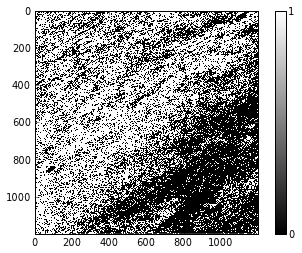

In [32]:
import numpy as np
import pylab as plt

qc = data['FparLai_QC'] # Get the QC data
# Create a mask like the LAI product
mask = np.zeros_like(lai).astype(bool)
# Fill the mask where the conditions are met
mask = np.where ( qc == 0, True, False )
mask = np.where ( qc == 1, True, mask )

# Select a black/white colormap
cmap = plt.cm.gray
# plot the data
plt.imshow(mask, interpolation='nearest', cmap=cmap)
# add a colorbar
plt.colorbar(ticks=[0,1])

To plot LAI only for the valid pixels (`mask == True`). We can used masked arrays for this. Masked arrays are like normal arrays, but they have an associated mask, which in this case is `mask` define above. We shall also choose another colormap (there are [lots to choose from](http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps)), and set values outside the 0.1 and 4 to be shown as black pixels.

<matplotlib.colorbar.Colorbar instance at 0xd429e18>

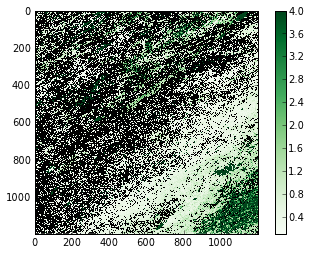

In [34]:
cmap = plt.cm.Greens
cmap.set_bad ( 'k' )
laim = np.ma.array ( lai, mask=mask )
plt.imshow ( laim, cmap=cmap, interpolation='nearest', vmin=0.1, vmax=4)
plt.colorbar()

Similarly, we can do a similar thing for Standard Deviation

<matplotlib.colorbar.Colorbar instance at 0x2b8ee20374d0>

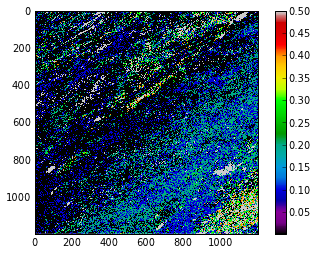

In [39]:
cmap = plt.cm.spectral
cmap.set_bad ( 'k' )
stdm = np.ma.array ( lai_sd, mask=mask )
plt.imshow ( stdm, cmap=cmap, interpolation='nearest', vmin=0.001, vmax=0.5)
plt.colorbar()

## Exercise 1

For the moment, we will suppose this data masking to be sufficient. However, 
closer inspection of the [product data]( https://lpdaac.usgs.gov/products/modis_products_table/leaf_area_index_fraction_of_photosynthetically_active_radiation/8_day_l4_global_1km/mod15a2) page would show us that the data can take on various Fill Values which any data user should check for.

Modify the code we have developed above to also check that the data are not unwanted ‘fill values’ and use this to modify the data mask.

*Hint* Note that these fill values are applied to Lai_1km, not the QC information, so you have to check values in that dataset and modify the mask accordingly.

## Exercise 2

We also have access to `FparExtra_QC`

    qc1  = data['FparExtra_QC']
    
The data values in FparExtra_QC are:


<table>
<tr>
<th>Bit No.</th>	<th>Parameter Name</th><th>	Bit Combination</th><th>Explanation</th>
<tr>
<td>0-1	</td><td>LandSea</td><td>	00</td><td>	Land</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	01	</td><td>Shore</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	10	</td><td>Freshwater</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	11	</td><td>Ocean</td>
</tr>
<tr>
<td>2	</td><td>Snow/Ice</td><td>	0</td><td>No snow/ice detected</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Snow/ice detected</td>
</tr>
<tr>
<td>3	</td><td>Aerosol</td><td>	0</td><td>No or low atmospheric aerosol levels detected</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Average or high atmospheric aerosol levels detected</td>
</tr>
<tr>
<td>4	</td><td>Cirrus</td><td>	0</td><td>No cirrus detected</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Cirrus detected</td>
</tr>
<tr>
<td>5	</td><td>Cloud</td><td>	0</td><td>No cloud detected</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Cloud detected</td>
</tr>
<tr>
<td>6	</td><td>Cloud shadow</td><td>	0</td><td>No cloud shadow detected</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Cloud shadowdetected</td>
</tr>
<tr>
<td>7	</td><td>Biome_mask</td><td>	0</td><td>Biome outside interval 1-4</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Biome in interval 1-4</td>
</tr>
</table>

Use this QC dataset to make sure that **only** Land pixels are passed in the mask, and apply other data quality measures as appropriate.

*Hint* this is much the same as the exercise above, but looking at a different QC dataset. The key to doing this is to identify the bit codes for combinations that you want to set or unset.

You can find an example of how to do this **here**[**DEADLINK**]. This filtering shouldn’t make much difference in this case, as the tile is mostly land pixels. However, consider tile h17v03 (part of the UK) for the month of June (e.g. `MCD15A2.A2011185.h17v03.005.2011213154608.hdf`)

**TODO** as NASA website is down!!!!!

![UK LAI map](https://raw.github.com/jgomezdans/geogg122-1/master/uk_lai.png)

In [45]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [35]:
def css_styling():
    from IPython.display import display, HTML
    styles = "https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/raw/master/styles/custom.css"
    return HTML(styles)
css_styling()